In [ ]:
"""
Created on 2019/03/03

DCGAN-SN using Keras
最大差別是loss是用原本GAN的JS-D

使用前要改一下Keras source code:
Ref: https://kexue.fm/archives/6051#Keras%E5%AE%9E%E7%8E%B0

Source: 
1. https://github.com/bojone/gan/blob/master/keras/dcgan_sn_celeba.py
"""

"""
觀念補充:

卷積output圖片size計算: N=(W−F+2P)/S+1
    輸入圖片矩陣為：WxW 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

逆卷積output圖片size計算: W=(N−1)∗S−2P+F
    輸入圖片矩陣為：NxN 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

"""

# Import

In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data preparation

## CelebA

In [20]:
if not os.path.exists('celebA_samples'):
    os.mkdir('celebA_samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/CelebA/img_align_celeba/")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

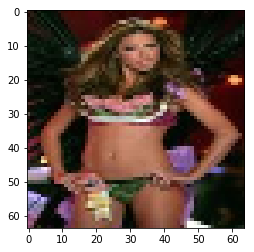

In [13]:
plt.imshow(read_img(imgs[2000]))

## Complex

In [6]:
if not os.path.exists('samples'):
    os.mkdir('samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/thumbnails_features_deduped_publish")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

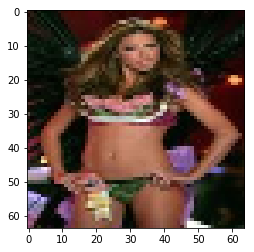

In [3]:
plt.imshow(read_img(imgs[2000]))

## Image training generator

In [7]:
def data_generator(batch_size=32):
    X = []
    while True:
        # print(123)
        np.random.shuffle(imgs)
        # 只要有yield就是generator，把生成器想成是中斷點還沒跑完的東西
        # 照理說叫了這個func，因為有while True，所以會一直無限迴圈while裡面東西
        # 但這裡因為圖片數量實在太多，所以一直卡在for path...這個loop裡
        for path in imgs:
            X.append(read_img(path))
            if len(X) == batch_size:
                # print(456)
                X = np.array(X)
                yield X
                X = []  # 所以這裡還要清空一波

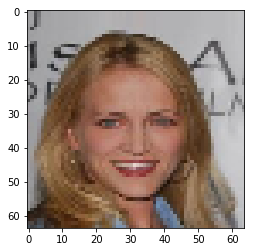

In [26]:
# x = data_generator()
plt.imshow(next(x)[0]) # (batch, 64, 64, 3)

# Model

## Hyperparameters

In [8]:
height, width = read_img(imgs[0]).shape[:2]
# center_height = int((height - width) / 2)
img_dim = 64
z_dim = 100

## Spectral norm

In [28]:
def spectral_norm(w, r=5):
    w_shape = K.int_shape(w)  # Returns the shape of tensor or variable as a tuple of int or None entries.
    print("w_shape", w_shape)
    in_dim = np.prod(w_shape[:-1]).astype(int)
    print("in_dim", in_dim)  
    out_dim = w_shape[-1]
    print("out_dim", out_dim) 
    w = K.reshape(w, (in_dim, out_dim))
    u = K.ones((1, in_dim))
    print("w dim", w.shape) 
    print("u dim", u.shape) 
    for i in range(r):
        # by row to divide the norm
        # power iteration
        v = K.l2_normalize(K.dot(u, w))
        u = K.l2_normalize(K.dot(v, K.transpose(w)))
    return K.sum(K.dot(K.dot(u, w), K.transpose(v)))  # get the max singular value


def spectral_normalization(w):
    return w / spectral_norm(w)

## Discriminator
`Discriminator的每層都要加normalization的限制`

In [29]:
x_in = Input(shape=(img_dim, img_dim, 3))
x = x_in

x = Conv2D(img_dim,
           (5, 5),
           strides=(2, 2),
           padding='same',
           kernel_constraint=spectral_normalization)(x)
x = LeakyReLU()(x)

for i in range(3):
    x = Conv2D(img_dim * 2**(i + 1),
               (5, 5),
               strides=(2, 2),
               padding='same',
               kernel_constraint=spectral_normalization)(x)
    x = BatchNormalization(gamma_constraint=spectral_normalization)(x)
    x = LeakyReLU()(x)

x = Flatten()(x)
x = Dense(1, use_bias=False,
          activation='sigmoid', # 因為loss有log，不能為負數
          kernel_constraint=spectral_normalization)(x) 

d_model = Model(x_in, x)
d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         819456    
__________

## Generator

In [9]:
height, width = read_img(imgs[0]).shape[:2]
img_dim = 64
z_dim = 100

z_in = Input(shape=(z_dim, ))
z = z_in

z = Dense(4 * 4 * img_dim * 8)(z)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Reshape((4, 4, img_dim * 8))(z)

for i in range(3):
    z = Conv2DTranspose(filters=img_dim * 4 // 2 ** i,
                       kernel_size=(5, 5),
                       strides= (2, 2),
                       padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

z = Conv2DTranspose(filters=3,
                   kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='same')(z)
z = Activation('tanh')(z)

g_model = Model(z_in, z)
g_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_1 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
__________

# Integrated Training

## Trained on trimed ClebA

In [32]:
g_model.load_weights("g_weights_dcgan_sn_align_celebA.h5")
d_model.load_weights("d_weights_dcgan_sn_align_celebA.h5")

# 訓練D
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))

d_model.trainable = True
g_model.trainable = False

x_fake = g_model(z_in)
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score])
# 用假圖分數 - 真圖分數(越小越好)

d_loss = K.mean(- K.log(x_real_score + 1e-9) - K.log(1 - x_fake_score + 1e-9))
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Discriminator")
d_train_model.summary()


# 訓練G
g_model.trainable = True
d_model.trainable = False

x_fake_score = d_model(g_model(z_in))  # 串起來
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(- K.log(x_fake_score + 1e-9)))
g_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Generator")
g_train_model.summary()

def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)

iters_per_drawing = 100
total_iter = 10000
batch_size = 128
img_generator = data_generator(batch_size)

for i in range(0, total_iter):
    for d in range(3):
        z_noise = np.random.randn(batch_size, z_dim)
        # 丟入batch_size的真圖和noise
        d_loss = d_train_model.train_on_batch([next(img_generator), z_noise], None)
    for g in range(1):
        z_noise = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_noise, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('celebA_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')

g_model.save_weights("g_weights_dcgan_sn_align_celebA.h5")
d_model.save_weights("d_weights_dcgan_sn_align_celebA.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Ba

iter: 0, d_loss: 0.20484278, g_loss: 2.48899
iter: 10, d_loss: 0.37686342, g_loss: 2.0195718
iter: 20, d_loss: 0.425987, g_loss: 1.9821229
iter: 30, d_loss: 0.54451966, g_loss: 2.0291479
iter: 40, d_loss: 0.45807922, g_loss: 1.8690395
iter: 50, d_loss: 0.42493317, g_loss: 1.8879573
iter: 60, d_loss: 0.3949412, g_loss: 1.800696
iter: 70, d_loss: 0.400832, g_loss: 2.035906
iter: 80, d_loss: 0.46942252, g_loss: 1.8849341
iter: 90, d_loss: 0.33556098, g_loss: 1.9798719
iter: 100, d_loss: 0.30223456, g_loss: 2.238545
iter: 110, d_loss: 0.33362478, g_loss: 2.357563
iter: 120, d_loss: 0.30400085, g_loss: 2.077899
iter: 130, d_loss: 0.3926012, g_loss: 1.844717
iter: 140, d_loss: 0.3081419, g_loss: 2.1534777
iter: 150, d_loss: 0.40844336, g_loss: 2.0000105
iter: 160, d_loss: 0.3869087, g_loss: 2.1249285
iter: 170, d_loss: 0.4601788, g_loss: 1.8715534
iter: 180, d_loss: 0.42572963, g_loss: 2.1156096
iter: 190, d_loss: 0.30695647, g_loss: 2.247792
iter: 200, d_loss: 0.3912586, g_loss: 2.0573058
i

iter: 1680, d_loss: 0.41163903, g_loss: 2.268091
iter: 1690, d_loss: 0.44082814, g_loss: 1.9894595
iter: 1700, d_loss: 0.48005724, g_loss: 1.7650149
iter: 1710, d_loss: 0.39480388, g_loss: 2.158761
iter: 1720, d_loss: 0.36720848, g_loss: 1.894381
iter: 1730, d_loss: 0.38290143, g_loss: 1.5587538
iter: 1740, d_loss: 0.3938809, g_loss: 1.865998
iter: 1750, d_loss: 0.3820992, g_loss: 1.6177595
iter: 1760, d_loss: 0.5622392, g_loss: 2.3123689
iter: 1770, d_loss: 0.41938993, g_loss: 1.5162065
iter: 1780, d_loss: 0.4369603, g_loss: 1.8119974
iter: 1790, d_loss: 0.41759968, g_loss: 2.0131056
iter: 1800, d_loss: 0.3426999, g_loss: 1.7540096
iter: 1810, d_loss: 0.43315148, g_loss: 1.6758828
iter: 1820, d_loss: 0.3625746, g_loss: 1.8428464
iter: 1830, d_loss: 0.44157112, g_loss: 1.5907273
iter: 1840, d_loss: 0.3882936, g_loss: 1.825119
iter: 1850, d_loss: 0.37198746, g_loss: 2.0050876
iter: 1860, d_loss: 0.37082675, g_loss: 1.524394
iter: 1870, d_loss: 0.41757864, g_loss: 1.9289818
iter: 1880, d

iter: 3340, d_loss: 0.36262283, g_loss: 1.9882795
iter: 3350, d_loss: 0.38728395, g_loss: 1.9334922
iter: 3360, d_loss: 0.39171278, g_loss: 1.9162234
iter: 3370, d_loss: 0.41242182, g_loss: 2.103687
iter: 3380, d_loss: 0.3632595, g_loss: 1.8659279
iter: 3390, d_loss: 0.4617525, g_loss: 2.0900445
iter: 3400, d_loss: 0.42890495, g_loss: 1.9660549
iter: 3410, d_loss: 0.35079953, g_loss: 1.8607503
iter: 3420, d_loss: 0.7167776, g_loss: 2.5796335
iter: 3430, d_loss: 0.45659813, g_loss: 1.7084727
iter: 3440, d_loss: 0.51599836, g_loss: 2.0030537
iter: 3450, d_loss: 0.4225132, g_loss: 1.6972473
iter: 3460, d_loss: 0.44037157, g_loss: 1.9979709
iter: 3470, d_loss: 0.3754892, g_loss: 2.0070198
iter: 3480, d_loss: 0.40230554, g_loss: 1.8579895
iter: 3490, d_loss: 0.4314591, g_loss: 1.9421327
iter: 3500, d_loss: 0.50559306, g_loss: 2.3061712
iter: 3510, d_loss: 0.36307365, g_loss: 1.8736765
iter: 3520, d_loss: 0.9284823, g_loss: 2.2581515
iter: 3530, d_loss: 0.5096997, g_loss: 1.6720251
iter: 354

iter: 5000, d_loss: 0.50003374, g_loss: 2.134169
iter: 5010, d_loss: 0.37421548, g_loss: 2.149243
iter: 5020, d_loss: 0.37355694, g_loss: 1.7076702
iter: 5030, d_loss: 0.35116905, g_loss: 1.7474515
iter: 5040, d_loss: 0.5296694, g_loss: 2.3116224
iter: 5050, d_loss: 0.5863068, g_loss: 2.6544485
iter: 5060, d_loss: 0.43125275, g_loss: 1.7335992
iter: 5070, d_loss: 0.4359885, g_loss: 1.6996117
iter: 5080, d_loss: 0.5078244, g_loss: 2.2777145
iter: 5090, d_loss: 0.5455817, g_loss: 1.4461014
iter: 5100, d_loss: 0.4360168, g_loss: 2.0088274
iter: 5110, d_loss: 0.3400241, g_loss: 1.9330869
iter: 5120, d_loss: 0.4156618, g_loss: 1.8982687
iter: 5130, d_loss: 0.30114347, g_loss: 2.2055373
iter: 5140, d_loss: 0.52905715, g_loss: 2.6074204
iter: 5150, d_loss: 0.60452056, g_loss: 1.491885
iter: 5160, d_loss: 0.63062644, g_loss: 1.9490232
iter: 5170, d_loss: 0.44534785, g_loss: 2.373092
iter: 5180, d_loss: 0.4690348, g_loss: 2.0542233
iter: 5190, d_loss: 1.071538, g_loss: 0.8058742
iter: 5200, d_l

iter: 6670, d_loss: 0.3943538, g_loss: 1.9396663
iter: 6680, d_loss: 0.446435, g_loss: 1.3827248
iter: 6690, d_loss: 0.40415585, g_loss: 2.1352065
iter: 6700, d_loss: 0.635683, g_loss: 1.4096452
iter: 6710, d_loss: 0.3692125, g_loss: 1.7326432
iter: 6720, d_loss: 0.5790738, g_loss: 1.4538593
iter: 6730, d_loss: 0.46381104, g_loss: 2.001204
iter: 6740, d_loss: 0.61408055, g_loss: 2.4558065
iter: 6750, d_loss: 0.3595265, g_loss: 2.242186
iter: 6760, d_loss: 0.44006902, g_loss: 2.0386653
iter: 6770, d_loss: 0.29983795, g_loss: 2.3758771
iter: 6780, d_loss: 0.36314833, g_loss: 1.6608602
iter: 6790, d_loss: 0.47963756, g_loss: 1.7020752
iter: 6800, d_loss: 0.4699666, g_loss: 2.1340766
iter: 6810, d_loss: 0.4495256, g_loss: 1.936226
iter: 6820, d_loss: 1.5525227, g_loss: 1.1948456
iter: 6830, d_loss: 0.62840694, g_loss: 2.2856374
iter: 6840, d_loss: 0.37616244, g_loss: 2.1786468
iter: 6850, d_loss: 0.6468836, g_loss: 1.3420334
iter: 6860, d_loss: 0.38204306, g_loss: 1.9507965
iter: 6870, d_l

iter: 8340, d_loss: 0.44258475, g_loss: 1.3629224
iter: 8350, d_loss: 0.3982919, g_loss: 2.063281
iter: 8360, d_loss: 0.45020568, g_loss: 2.2402215
iter: 8370, d_loss: 0.5049926, g_loss: 1.3212793
iter: 8380, d_loss: 0.42505658, g_loss: 1.8738873
iter: 8390, d_loss: 1.606078, g_loss: 2.208431
iter: 8400, d_loss: 0.48031068, g_loss: 2.1199737
iter: 8410, d_loss: 0.3463577, g_loss: 2.1278796
iter: 8420, d_loss: 0.4970212, g_loss: 1.3737012
iter: 8430, d_loss: 0.34423482, g_loss: 2.2958636
iter: 8440, d_loss: 0.4779135, g_loss: 2.4848893
iter: 8450, d_loss: 2.3963513, g_loss: 0.8434061
iter: 8460, d_loss: 0.48362434, g_loss: 1.9769969
iter: 8470, d_loss: 0.50893897, g_loss: 1.8252666
iter: 8480, d_loss: 0.4882537, g_loss: 1.9952416
iter: 8490, d_loss: 0.34280768, g_loss: 1.91952
iter: 8500, d_loss: 0.357755, g_loss: 2.155634
iter: 8510, d_loss: 0.39327884, g_loss: 2.0081863
iter: 8520, d_loss: 0.43703815, g_loss: 1.9618224
iter: 8530, d_loss: 0.46668735, g_loss: 2.3790898
iter: 8540, d_lo

In [15]:
g_model.load_weights("g_weights_dcgan_sn_align_celebA.h5")

n = 9
img_dim = 64
z_dim = 100
figure = np.zeros((img_dim * n, img_dim * n, 3))
for i in range(n):
    for j in range(n):
        z_sample = np.random.randn(1, z_dim)
        x_sample = g_model.predict(z_sample)
        digit = read_img(imgs[np.random.randint(low=0, high=20000)]) # x_sample[0]
        figure[i * img_dim:(i + 1) * img_dim,
               j * img_dim:(j + 1) * img_dim] = digit
# figure = (figure + 1) / 2 * 255
figure = figure * 255
figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
figure = np.round(figure, 0).astype(int)
cv2.imwrite('celebA_samples/ppt_origin_data_1.png', figure)

True

## Train on 複雜頭像

In [12]:
g_model.load_weights("g_weights_dcgan_sn_complex.h5")
d_model.load_weights("d_weights_dcgan_sn_complex.h5")

# 訓練D
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))

d_model.trainable = True
g_model.trainable = False

x_fake = g_model(z_in)
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score])
# 用假圖分數 - 真圖分數(越小越好)

d_loss = K.mean(- K.log(x_real_score + 1e-9) - K.log(1 - x_fake_score + 1e-9))
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Discriminator")
d_train_model.summary()


# 訓練G
g_model.trainable = True
d_model.trainable = False

x_fake_score = d_model(g_model(z_in))  # 串起來
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(- K.log(x_fake_score + 1e-9)))
g_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))

print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()
print("Integrated Generator")
g_train_model.summary()

def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)

iters_per_drawing = 100
total_iter = 15000
batch_size = 64
img_generator = data_generator(batch_size)

for i in range(10000, total_iter):
    for d in range(3):
        z_noise = np.random.randn(batch_size, z_dim)
        # 丟入batch_size的真圖和noise
        d_loss = d_train_model.train_on_batch([next(img_generator), z_noise], None)
    for g in range(1):
        z_noise = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_noise, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('complex_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')

# g_model.save_weights("g_weights_dcgan_sn_complex.h5")
# d_model.save_weights("d_weights_dcgan_sn_complex.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_1 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Bat

iter: 10000, d_loss: 0.3325886, g_loss: 1.0657632
iter: 10010, d_loss: 0.41853666, g_loss: 1.0373452
iter: 10020, d_loss: 0.25953364, g_loss: 2.8488846
iter: 10030, d_loss: 0.30521628, g_loss: 2.308527
iter: 10040, d_loss: 0.26938087, g_loss: 2.150906
iter: 10050, d_loss: 0.2601667, g_loss: 2.4478266
iter: 10060, d_loss: 0.26777285, g_loss: 2.3852625


KeyboardInterrupt: 

# Custom Layers Bug

In [14]:
# 有custom layers先用load_weights (load_model待解)
# https://github.com/keras-team/keras/issues/4871
# weights用法: https://morvanzhou.github.io/tutorials/machine-learning/keras/3-1-save/

# g_model = load_model('g_model_20190303.h5')
# d_model = load_model('d_model_20190303.h5', 
#                      custom_objects={"spectral_normalization": spectral_normalization})

# g_model.save("g_model_20190303.h5")
# d_model.save("d_model_20190303.h5")

# Training Pipeline

實作GAN順序:
1. 資料準備: 真實資料、生成假資料的維度and分佈
2. 建立Generator
3. 建立Discriminator
4. 訓練D(每層有加Spectral Norm):
    - 4.1 準備好真假圖資料(Input維度)
    - 4.2 G.trainable = False (訓練D)
    - 4.3 把真假圖、Label、Loss、Train法決定好，串起來(Model(Input, Score))並compile
        以上面code來說，因為loss要照WGAN-GP，所以先把真假圖和GP的分數準備好，
        串起來後用add_loss加進模型，再compile
5. 訓練G:
    - 5.1 G.trainable = True, D.trainable = False
    - 5.2 準備好noise(和Label)，讓G生圖給D判別並給予分數D(G(noise)) 
    - 5.3 串起來Model(Input, 假圖分數)，然後compile
6. 開始對抗訓練
    - 6.1 Train D，丟入一樣batch_size的真假樣本，train_on_batch更新(可以for loop Train 5次)
    - 6.2 Train G，丟入batch_size的假樣本，train_on_batch更新，讓它生成的圖真一點
    - 6.3 可配合畫圖函數，固定迭代數畫圖
7. Loss怎麼看?
    - 7.1 D跟G都是越小越好
    - 7.2 G: loss有加負號，值越小表示圖像越逼真(fake_score是高的)
    - 7.3 D: loss也有加負號，真假圖分越開，會負越多；如果是正的代表G的圖反而比較強